In [1]:
import os
from pathlib import Path
import re
import warnings

from dotenv import find_dotenv, load_dotenv
from IPython.display import display
from rich import print as rprint
from rich.markdown import Markdown
from rich.pretty import Pretty
from rich.text import Text

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
load_dotenv(find_dotenv('.env'))

True

In [4]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 14 (Indexing - ColBERT)"

In [5]:
DATA_PATH = Path('../../data')

# Indexing

![](images/indexing-01.png)

# Part 14: ColBERT

![](images/14-01-colbert.png)

![](images/14-02-colbert.jpg)

## Configure components

In [6]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [7]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=1
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BKPueXufJHLtjqQ7UK2irCMmUtSGA', 'finish_reason': 'stop', 'logprobs': None}, id='run-19a8c321-b21d-4606-8a03-17487eedc7aa-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [8]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
len(embeddings.embed_query("Hello"))

1536

## Load documents

In [9]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [10]:
articles = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-02-05-human-data-quality/",
]

loader = WebBaseLoader(
    web_paths=articles,
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

2

In [11]:
print(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

In [12]:
print(docs[1].page_content[:1000])



      Thinking about High-Quality Human Data
    
Date: February 5, 2024  |  Estimated Reading Time: 21 min  |  Author: Lilian Weng


[Special thank you to Ian Kivlichan for many useful pointers (E.g. the 100+ year old Nature paper “Vox populi”) and nice feedback. 🙏 ]
High-quality data is the fuel for modern data deep learning model training. Most of the task-specific labeled data comes from human annotation, such as classification task or RLHF labeling (which can be constructed as classification format) for LLM alignment training. Lots of ML techniques in the post can help with data quality, but fundamentally human data collection involves attention to details and careful execution. The community knows the value of high quality data, but somehow we have this subtle impression that “Everyone wants to do the model work, not the data work” (Sambasivan et al. 2021).

Fig. 1. Two directions to approach high data quality.
Human Raters ↔ Data Quality#


In [13]:
[len(doc.page_content) for doc in docs]

[43130, 29018]

## Split documents

In [14]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [16]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=0)
splits = text_splitter.split_documents(docs)
len(splits)

99

## Store documents

In [17]:
# Use transformers==4.49.0
# https://github.com/huggingface/transformers/issues/36954

In [18]:
from langchain_core.vectorstores import InMemoryVectorStore
from ragatouille import RAGPretrainedModel

In [19]:
vectorstore = InMemoryVectorStore(embeddings)
doc_ids = vectorstore.add_documents(documents=splits)
len(doc_ids), len(vectorstore.store)

(99, 99)

In [20]:
# https://github.com/AnswerDotAI/RAGatouille/issues/213#issuecomment-2285897809

RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

[Apr 09, 16:38:11] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/home/dlabazkin/projects/gpt/llm-rag/.venv/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [21]:
docs_texts = [doc.page_content for doc in splits]
docs_metadatas = [doc.metadata for doc in splits]

In [ ]:
RAG.index(
    collection=docs_texts,
    document_metadatas=docs_metadatas,
    index_name="blog",
    split_documents=False,
)

---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Apr 09, 16:38:11] #> Note: Output directory .ragatouille/colbert/indexes/blog already exists


[Apr 09, 16:38:11] #> Will delete 11 files already at .ragatouille/colbert/indexes/blog in 20 seconds...
[Apr 09, 16:38:34] [0] 		 #> Encoding 99 passages..


  0%|                                                                                                                           | 0/4 [00:00<?, ?it/s]/home/dlabazkin/projects/gpt/llm-rag/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
 50%|█████████████████████████████████████████████████████████▌                                                         | 2/4 [00:22<00:22, 11.34s/it]

## RAG

In [22]:
rag_prompt_template = """Answer the following question based on this context:

{context}

Question: {question}"""
print(rag_prompt_template)

Answer the following question based on this context:

{context}

Question: {question}


In [23]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [24]:
search_kwargs = {
    "k": 10
}

In [25]:
queries = [
    "What is task decomposition for LLM agents?",
    "What are main steps for collecting human data?"
]

### Reranker

In [26]:
from langchain.retrievers import ContextualCompressionRetriever

In [27]:
retriever = vectorstore.as_retriever(
    search_kwargs=search_kwargs
)

compression_retriever = ContextualCompressionRetriever(
    base_compressor=RAG.as_langchain_document_compressor(k=search_kwargs["k"]), base_retriever=retriever
)

for query in queries:
    print(query)
    docs = retriever.invoke(query)
    compressed_docs = compression_retriever.invoke(query)
    
    chunk_pattern = re.compile(r'^Chunk \d+.*:$', flags=re.MULTILINE)
    terms_pattern = re.compile(rf'\b({"|".join(query.split())})\b', flags=re.IGNORECASE)
    
    for chunk_id, (doc, compressed_doc) in enumerate(zip(docs, compressed_docs), start=1):
        text = Text(f"Chunk {chunk_id}:\n{doc.page_content}")
        text.highlight_regex(chunk_pattern, "bold green")
        text.highlight_regex(terms_pattern, "underline red")
        rprint(text)

        text = Text(f"Chunk {chunk_id} (compressed):\n{compressed_doc.page_content}")
        text.highlight_regex(chunk_pattern, "bold green")
        text.highlight_regex(terms_pattern, "underline red")
        rprint(text)

What is task decomposition for LLM agents?


/home/dlabazkin/projects/gpt/rag-explore/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


Chunk 1:
Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#

Chunk 1 (compressed):
Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#

Chunk 2:
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals 
for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or
(3) with human inputs.

Chunk 2 (compressed):
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals 
for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or
(3) with human inputs.

Chunk 3:
Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts
demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends 
beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem
solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key 
components:

Planning

Chunk 3 (compressed):
Challenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring 
the solution space remain challenging. LLMs struggle to adjust plans when faced with unexpected errors, making them
less robust compared to humans who learn from trial and error.

Chunk 4:
Challenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring 
the solution space remain challenging. LLMs struggle to adjust plans when faced with unexpected errors, making them
less robust compared to humans who learn from trial and error.

Chunk 4 (compressed):
Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient 
handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from 
mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Chunk 5:
(2) Model selection: LLM distributes the tasks to expert models, where the request is framed as a multiple-choice 
question. LLM is presented with a list of models to choose from. Due to the limited context length, task type based
filtration is needed.
Instruction:

Chunk 5 (compressed):
(2) Model selection: LLM distributes the tasks to expert models, where the request is framed as a multiple-choice 
question. LLM is presented with a list of models to choose from. Due to the limited context length, task type based
filtration is needed.
Instruction:

Chunk 6:
Fig. 11. Illustration of how HuggingGPT works. (Image source: Shen et al. 2023)
The system comprises of 4 stages:
(1) Task planning: LLM works as the brain and parses the user requests into multiple tasks. There are four 
attributes associated with each task: task type, ID, dependencies, and arguments. They use few-shot examples to 
guide LLM to do task parsing and planning.
Instruction:

Chunk 6 (compressed):
Fig. 11. Illustration of how HuggingGPT works. (Image source: Shen et al. 2023)
The system comprises of 4 stages:
(1) Task planning: LLM works as the brain and parses the user requests into multiple tasks. There are four 
attributes associated with each task: task type, ID, dependencies, and arguments. They use few-shot examples to 
guide LLM to do task parsing and planning.
Instruction:

Chunk 7:
Boiko et al. (2023) also looked into LLM-empowered agents for scientific discovery, to handle autonomous design, 
planning, and performance of complex scientific experiments. This agent can use tools to browse the Internet, read 
documentation, execute code, call robotics experimentation APIs and leverage other LLMs.
For example, when requested to "develop a novel anticancer drug", the model came up with the following reasoning 
steps:

Chunk 7 (compressed):
Boiko et al. (2023) also looked into LLM-empowered agents for scientific discovery, to handle autonomous design, 
planning, and performance of complex scientific experiments. This agent can use tools to browse the Internet, read 
documentation, execute code, call robotics experimentation APIs and leverage other LLMs.
For example, when requested to "develop a novel anticancer drug", the model came up with the following reasoning 
steps:

Chunk 8:
Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient 
handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from 
mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Chunk 8 (compressed):
Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts
demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends 
beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem
solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key 
components:

Planning

Chunk 9:
}
]
Challenges#
After going through key ideas and demos of building LLM-centered agents, I start to see a couple common 
limitations:

Chunk 9 (compressed):
(4) Response generation: LLM receives the execution results and provides summarized results to users.
To put HuggingGPT into real world usage, a couple challenges need to solve: (1) Efficiency improvement is needed as
both LLM inference rounds and interactions with other models slow down the process; (2) It relies on a long context
window to communicate over complicated task content; (3) Stability improvement of LLM outputs and external model 
services.

Chunk 10:
(4) Response generation: LLM receives the execution results and provides summarized results to users.
To put HuggingGPT into real world usage, a couple challenges need to solve: (1) Efficiency improvement is needed as
both LLM inference rounds and interactions with other models slow down the process; (2) It relies on a long context
window to communicate over complicated task content; (3) Stability improvement of LLM outputs and external model 
services.

Chunk 10 (compressed):
}
]
Challenges#
After going through key ideas and demos of building LLM-centered agents, I start to see a couple common 
limitations:

What are main steps for collecting human data?


/home/dlabazkin/projects/gpt/rag-explore/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


Chunk 1:
Fig. 1. Two directions to approach high data quality.
Human Raters ↔ Data Quality#
Collecting human data involve a set of operation steps and every step contributes to the data quality:

Chunk 1 (compressed):
Fig. 1. Two directions to approach high data quality.
Human Raters ↔ Data Quality#
Collecting human data involve a set of operation steps and every step contributes to the data quality:

Chunk 2:
Or
@article{weng2024humandata,
  title   = "Thinking about High-Quality Human Data",
  author  = "Weng, Lilian",
  journal = "lilianweng.github.io",
  year    = "2024",
  month   = "Feb",
  url     = "https://lilianweng.github.io/posts/2024-02-05-human-data-quality/"
}
References#
[1] Francis Galton “Vox populi”  Nature 75, 450-451 (1907).
[2] Sambasivan et al. “Everyone wants to do the model work, not the data work”: Data Cascades in High-Stakes AI" 
CHI 2021

Chunk 2 (compressed):
High-quality data is the fuel for modern data deep learning model training. Most of the task-specific labeled data 
comes from human annotation, such as classification task or RLHF labeling (which can be constructed as 
classification format) for LLM alignment training. Lots of ML techniques in the post can help with data quality, 
but fundamentally human data collection involves attention to details and careful execution. The community knows 
the value of high quality data, but somehow we have this subtle

Chunk 3:
Thinking about High-Quality Human Data
    
Date: February 5, 2024  |  Estimated Reading Time: 21 min  |  Author: Lilian Weng

Chunk 3 (compressed):
Collect and aggregate data. This is the stage where more ML techniques can be applied to clean, filter and smartly 
aggregate data to identify the true labels.

Chunk 4:
Collect and aggregate data. This is the stage where more ML techniques can be applied to clean, filter and smartly 
aggregate data to identify the true labels.

Chunk 4 (compressed):
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals 
for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or
(3) with human inputs.

Chunk 5:
High-quality data is the fuel for modern data deep learning model training. Most of the task-specific labeled data 
comes from human annotation, such as classification task or RLHF labeling (which can be constructed as 
classification format) for LLM alignment training. Lots of ML techniques in the post can help with data quality, 
but fundamentally human data collection involves attention to details and careful execution. The community knows 
the value of high quality data, but somehow we have this subtle

Chunk 5 (compressed):
Fig. 15. Algorithm of INCV (iterative noisy cross-validation). (Image source: Chen et al. 2019)
Citation#
Cited as:

Weng, Lilian. (Feb 2024). “Thinking about High-Quality Human Data”. Lil’Log. 
https://lilianweng.github.io/posts/2024-02-05-human-data-quality/.

Chunk 6:
Prompt LM with 100 most recent observations and to generate 3 most salient high-level questions given a set of 
observations/statements. Then ask LM to answer those questions.


Planning & Reacting: translate the reflections and the environment information into actions

Chunk 6 (compressed):
Thinking about High-Quality Human Data
    
Date: February 5, 2024  |  Estimated Reading Time: 21 min  |  Author: Lilian Weng

Chunk 7:
With the input and the inference results, the AI assistant needs to describe the process and results. The previous 
stages can be formed as - User Input: {{ User Input }}, Task Planning: {{ Tasks }}, Model Selection: {{ Model 
Assignment }}, Task Execution: {{ Predictions }}. You must first answer the user's request in a straightforward 
manner. Then describe the task process and show your analysis and model inference results to the user in the first 
person. If inference results contain a file path, must tell

Chunk 7 (compressed):
Or
@article{weng2024humandata,
  title   = "Thinking about High-Quality Human Data",
  author  = "Weng, Lilian",
  journal = "lilianweng.github.io",
  year    = "2024",
  month   = "Feb",
  url     = "https://lilianweng.github.io/posts/2024-02-05-human-data-quality/"
}
References#
[1] Francis Galton “Vox populi”  Nature 75, 450-451 (1907).
[2] Sambasivan et al. “Everyone wants to do the model work, not the data work”: Data Cascades in High-Stakes AI" 
CHI 2021

Chunk 8:
Fig. 15. Algorithm of INCV (iterative noisy cross-validation). (Image source: Chen et al. 2019)
Citation#
Cited as:

Weng, Lilian. (Feb 2024). “Thinking about High-Quality Human Data”. Lil’Log. 
https://lilianweng.github.io/posts/2024-02-05-human-data-quality/.

Chunk 8 (compressed):
With the input and the inference results, the AI assistant needs to describe the process and results. The previous 
stages can be formed as - User Input: {{ User Input }}, Task Planning: {{ Tasks }}, Model Selection: {{ Model 
Assignment }}, Task Execution: {{ Predictions }}. You must first answer the user's request in a straightforward 
manner. Then describe the task process and show your analysis and model inference results to the user in the first 
person. If inference results contain a file path, must tell

Chunk 9:
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals 
for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or
(3) with human inputs.

Chunk 9 (compressed):
Prompt LM with 100 most recent observations and to generate 3 most salient high-level questions given a set of 
observations/statements. Then ask LM to answer those questions.


Planning & Reacting: translate the reflections and the environment information into actions

Chunk 10:
Task design: Design task workflow to improve clarity and reduce complexity. Detailed guidelines are helpful but 
very long and complicated guidelines demand a decent amount of training to be useful.
Select and train a pool of raters: Select annotators with matched skillset and consistency. Training sessions are 
necessary. After onboarding, regular feedback and calibration sessions are also needed.

Chunk 10 (compressed):
Task design: Design task workflow to improve clarity and reduce complexity. Detailed guidelines are helpful but 
very long and complicated guidelines demand a decent amount of training to be useful.
Select and train a pool of raters: Select annotators with matched skillset and consistency. Training sessions are 
necessary. After onboarding, regular feedback and calibration sessions are also needed.

### Retriever

In [33]:
from typing import TypedDict

from langchain_core.documents import Document
from langgraph.graph import END, START, StateGraph
from langchain_core.messages import HumanMessage

In [28]:
retriever = RAG.as_langchain_retriever(k=search_kwargs["k"])

for query in queries:
    print(query)
    docs = retriever.invoke(query)
    rprint(docs)

    chunk_pattern = re.compile(r'^Chunk \d+.*:$', flags=re.MULTILINE)
    terms_pattern = re.compile(rf'\b({"|".join(query.split())})\b', flags=re.IGNORECASE)
    
    for chunk_id, doc in enumerate(docs, start=1):
        text = Text(f"Chunk {chunk_id}:\n{doc.page_content}")
        text.highlight_regex(chunk_pattern, "bold green")
        text.highlight_regex(terms_pattern, "underline red")
        rprint(text)

What is task decomposition for LLM agents?
Loading searcher for index blog for the first time... This may take a few seconds
[Apr 08, 14:53:52] #> Loading codec...
[Apr 08, 14:53:52] #> Loading IVF...
[Apr 08, 14:53:52] Loading segmented_lookup_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/home/dlabazkin/projects/gpt/rag-explore/.venv/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


[Apr 08, 14:53:52] #> Loading doclens...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6278.90it/s]

[Apr 08, 14:53:52] #> Loading codes and residuals...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 468.95it/s]

[Apr 08, 14:53:52] Loading filter_pids_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


[Apr 08, 14:53:52] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is task decomposition for LLM agents?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  4708, 22511,  2005,  2222,  2213,  6074,
         1029,   102,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])



/home/dlabazkin/projects/gpt/rag-explore/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA 
complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask 
Decomposition#'
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", 
"What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." 
for writing a novel, or (3) with human inputs.'
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='Challenges in long-term planning and task decomposition: Planning over a lengthy history and 
effectively exploring the solution space remain challenging. LLMs struggle to adjust plans when faced with 
unexpected errors, making them less robust compared to humans who learn from trial and error.'
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable 
subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism
and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the 
quality of final results.\n\n\nMemory'
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='Case Studies#\nScientific Discovery Agent#\nChemCrow (Bran et al. 2023) is a domain-specific 
example in which LLM is augmented with 13 expert-designed tools to accomplish tasks across organic synthesis, drug 
discovery, and materials design. The workflow, implemented in LangChain, reflects what was previously described in 
the ReAct and MRKLs and combines CoT reasoning with tools relevant to the tasks:'
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='(2) Model selection: LLM distributes the tasks to expert models, where the request is framed 
as a multiple-choice question. LLM is presented with a list of models to choose from. Due to the limited context 
length, task type based filtration is needed.\nInstruction:'
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='Generative Agents (Park, et al. 2023) is super fun experiment where 25 virtual characters, 
each controlled by a LLM-powered agent, are living and interacting in a sandbox environment, inspired by The Sims. 
Generative agents create believable simulacra of human behavior for interactive applications.\nThe design of 
generative agents combines LLM with memory, planning and reflection mechanisms to enable agents to behave 
conditioned on past experience, as well as to interact with other agents.'
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='MRKL (Karpas et al. 2022), short for “Modular Reasoning, Knowledge and Language”, is a 
neuro-symbolic architecture for autonomous agents. A MRKL system is proposed to contain a collection of “expert” 
modules and the general-purpose LLM works as a router to route inquiries to the best suitable expert module. These 
modules can be neural (e.g. deep learning models) or symbolic (e.g. math calculator, currency converter, weather 
API).'
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='ReAct (Yao et al. 2023) integrates reasoning and acting within LLM by extending the action 
space to be a combinat

Chunk 1:
Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#

Chunk 2:
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals 
for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or
(3) with human inputs.

Chunk 3:
Challenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring 
the solution space remain challenging. LLMs struggle to adjust plans when faced with unexpected errors, making them
less robust compared to humans who learn from trial and error.

Chunk 4:
Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient 
handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from 
mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Chunk 5:
Case Studies#
Scientific Discovery Agent#
ChemCrow (Bran et al. 2023) is a domain-specific example in which LLM is augmented with 13 expert-designed tools to
accomplish tasks across organic synthesis, drug discovery, and materials design. The workflow, implemented in 
LangChain, reflects what was previously described in the ReAct and MRKLs and combines CoT reasoning with tools 
relevant to the tasks:

Chunk 6:
(2) Model selection: LLM distributes the tasks to expert models, where the request is framed as a multiple-choice 
question. LLM is presented with a list of models to choose from. Due to the limited context length, task type based
filtration is needed.
Instruction:

Chunk 7:
Generative Agents (Park, et al. 2023) is super fun experiment where 25 virtual characters, each controlled by a 
LLM-powered agent, are living and interacting in a sandbox environment, inspired by The Sims. Generative agents 
create believable simulacra of human behavior for interactive applications.
The design of generative agents combines LLM with memory, planning and reflection mechanisms to enable agents to 
behave conditioned on past experience, as well as to interact with other agents.

Chunk 8:
MRKL (Karpas et al. 2022), short for “Modular Reasoning, Knowledge and Language”, is a neuro-symbolic architecture 
for autonomous agents. A MRKL system is proposed to contain a collection of “expert” modules and the 
general-purpose LLM works as a router to route inquiries to the best suitable expert module. These modules can be 
neural (e.g. deep learning models) or symbolic (e.g. math calculator, currency converter, weather API).

Chunk 9:
ReAct (Yao et al. 2023) integrates reasoning and acting within LLM by extending the action space to be a 
combination of task-specific discrete actions and the language space. The former enables LLM to interact with the 
environment (e.g. use Wikipedia search API), while the latter prompting LLM to generate reasoning traces in natural
language.
The ReAct prompt template incorporates explicit steps for LLM to think, roughly formatted as:
Thought: ...
Action: ...
Observation: ...
... (Repeated many times)

Chunk 10:
Fig. 11. Illustration of how HuggingGPT works. (Image source: Shen et al. 2023)
The system comprises of 4 stages:
(1) Task planning: LLM works as the brain and parses the user requests into multiple tasks. There are four 
attributes associated with each task: task type, ID, dependencies, and arguments. They use few-shot examples to 
guide LLM to do task parsing and planning.
Instruction:

/home/dlabazkin/projects/gpt/rag-explore/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


What are main steps for collecting human data?


[
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
        page_content='Fig. 1. Two directions to approach high data quality.\nHuman Raters ↔ Data 
Quality#\nCollecting human data involve a set of operation steps and every step contributes to the data quality:'
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
        page_content='High-quality data is the fuel for modern data deep learning model training. Most of the 
task-specific labeled data comes from human annotation, such as classification task or RLHF labeling (which can be 
constructed as classification format) for LLM alignment training. Lots of ML techniques in the post can help with 
data quality, but fundamentally human data collection involves attention to details and careful execution. The 
community knows the value of high quality data, but somehow we have this subtle'
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
        page_content='Collect and aggregate data. This is the stage where more ML techniques can be applied to 
clean, filter and smartly aggregate data to identify the true labels.'
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='Memory can be defined as the processes used to acquire, store, retain, and later retrieve 
information. There are several types of memory in human brains.'
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='Chain of Hindsight (CoH; Liu et al. 2023) encourages the model to improve on its own outputs 
by explicitly presenting it with a sequence of past outputs, each annotated with feedback. Human feedback data is a
collection of $D_h = \\{(x, y_i , r_i , z_i)\\}_{i=1}^n$, where $x$ is the prompt, each $y_i$ is a model 
completion, $r_i$ is the human rating of $y_i$, and $z_i$ is the corresponding human-provided hindsight feedback. 
Assume the feedback tuples are ranked by reward, $r_n \\geq r_{n-1} \\geq \\dots \\geq'
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
        page_content='Aroyo & Welty (2015) discussed a set of “myths” in the practice of human annotation 
collection and found all of them somewhat inaccurate, key findings including:'
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", 
"What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." 
for writing a novel, or (3) with human inputs.'
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
        page_content='In a harder task, non-expert human annotators were asked to create new gold reference 
translations. Callison-Burch designed the task in two stages, where the first stage created new translations with 
reference to MT outputs and the second one filtered translations that may seem to be gerated by a MT system. The 
correlation between experts’ and crowdsourced translations is higher than that between expert and MT system 
outputs.'
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='Resources:\n1. Internet access for searches and information gathering.\n2. Long Term memory 
management.\n3. GPT-3.5 powered Agents for delegation of simple tasks.\n4. File output.'
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
        page_content='Almost 100 years later, Callison-Burch (2009) did an early study on us

Chunk 1:
Fig. 1. Two directions to approach high data quality.
Human Raters ↔ Data Quality#
Collecting human data involve a set of operation steps and every step contributes to the data quality:

Chunk 2:
High-quality data is the fuel for modern data deep learning model training. Most of the task-specific labeled data 
comes from human annotation, such as classification task or RLHF labeling (which can be constructed as 
classification format) for LLM alignment training. Lots of ML techniques in the post can help with data quality, 
but fundamentally human data collection involves attention to details and careful execution. The community knows 
the value of high quality data, but somehow we have this subtle

Chunk 3:
Collect and aggregate data. This is the stage where more ML techniques can be applied to clean, filter and smartly 
aggregate data to identify the true labels.

Chunk 4:
Memory can be defined as the processes used to acquire, store, retain, and later retrieve information. There are 
several types of memory in human brains.

Chunk 5:
Chain of Hindsight (CoH; Liu et al. 2023) encourages the model to improve on its own outputs by explicitly 
presenting it with a sequence of past outputs, each annotated with feedback. Human feedback data is a collection of
$D_h = \{(x, y_i , r_i , z_i)\}_{i=1}^n$, where $x$ is the prompt, each $y_i$ is a model completion, $r_i$ is the 
human rating of $y_i$, and $z_i$ is the corresponding human-provided hindsight feedback. Assume the feedback tuples
are ranked by reward, $r_n \geq r_{n-1} \geq \dots \geq

Chunk 6:
Aroyo & Welty (2015) discussed a set of “myths” in the practice of human annotation collection and found all of 
them somewhat inaccurate, key findings including:

Chunk 7:
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals 
for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or
(3) with human inputs.

Chunk 8:
In a harder task, non-expert human annotators were asked to create new gold reference translations. Callison-Burch 
designed the task in two stages, where the first stage created new translations with reference to MT outputs and 
the second one filtered translations that may seem to be gerated by a MT system. The correlation between experts’ 
and crowdsourced translations is higher than that between expert and MT system outputs.

Chunk 9:
Resources:
1. Internet access for searches and information gathering.
2. Long Term memory management.
3. GPT-3.5 powered Agents for delegation of simple tasks.
4. File output.

Chunk 10:
Almost 100 years later, Callison-Burch (2009) did an early study on using Amazon Mechanical Turk (AMT) to run 
non-expert human evaluation on Machine Translation (MT) tasks and even to rely on non-experts to create new gold 
reference translations. The setup for human evaluation was simple: Each turker is shown a source sentence, a 
reference translation, and 5 translations from 5 MT systems. They are asked to rank 5 translations from best to 
worst. Each task is completed by 5 turkers.

In [35]:
class State(TypedDict):
    question: str
    context: list[Document]
    answer: str

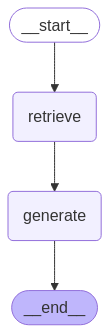

In [36]:
def retrieve(state: State):
    retrieved_docs = retriever.invoke(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = format_docs(state["context"])
    rag_prompt = rag_prompt_template.format(
        question=state["question"],
        context=docs_content
    )
    response = llm.invoke([
        HumanMessage(content=rag_prompt)
    ])
    return {"answer": response.content}


graph_builder = StateGraph(State)

graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)

graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()
graph

In [37]:
for query in queries:
    print(query)
    response = graph.invoke({"question": query})
    rprint(Pretty(response, no_wrap=False))
    rprint(Markdown(response["answer"]))

What is task decomposition for LLM agents?


/home/dlabazkin/projects/gpt/rag-explore/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


{
    'question': 'What is task decomposition for LLM agents?',
    'context': [
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA 
complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask 
Decomposition#'
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for 
XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a 
story outline." for writing a novel, or (3) with human inputs.'
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Challenges in long-term planning and task decomposition: Planning over a lengthy history 
and effectively exploring the solution space remain challenging. LLMs struggle to adjust plans when faced with 
unexpected errors, making them less robust compared to humans who learn from trial and error.'
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable 
subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism
and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the 
quality of final results.\n\n\nMemory'
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Case Studies#\nScientific Discovery Agent#\nChemCrow (Bran et al. 2023) is a 
domain-specific example in which LLM is augmented with 13 expert-designed tools to accomplish tasks across organic 
synthesis, drug discovery, and materials design. The workflow, implemented in LangChain, reflects what was 
previously described in the ReAct and MRKLs and combines CoT reasoning with tools relevant to the tasks:'
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='(2) Model selection: LLM distributes the tasks to expert models, where the request is 
framed as a multiple-choice question. LLM is presented with a list of models to choose from. Due to the limited 
context length, task type based filtration is needed.\nInstruction:'
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Generative Agents (Park, et al. 2023) is super fun experiment where 25 virtual 
characters, each controlled by a LLM-powered agent, are living and interacting in a sandbox environment, inspired 
by The Sims. Generative agents create believable simulacra of human behavior for interactive applications.\nThe 
design of generative agents combines LLM with memory, planning and reflection mechanisms to enable agents to behave
conditioned on past experience, as well as to interact with other agents.'
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='MRKL (Karpas et al. 2022), short for “Modular Reasoning, Knowledge and Language”, is a 
neuro-symbolic architecture for autonomous agents. A MRKL system is proposed to contain a collection of “expert” 
modules and the general-purpose LLM works as a router to route inquiries to the best suitable expert module. These 
modules can be neural (e.g. deep learning models) or symbolic (e.g. math calculator, currency converter, weather 
API).'
        ),
        Document(
           

Task decomposition for LLM (Large Language Model) agents refers to the process of breaking down a complicated task 
into smaller, manageable subgoals or steps. This allows the agent to efficiently tackle complex tasks by providing 
a clearer structure for action. Task decomposition can be achieved in several ways:                                

 1 Simple Prompting: LLMs can generate steps for a task by using prompts like "Steps for XYZ.\n1." or by asking    
   questions such as "What are the subgoals for achieving XYZ?".                                                   
 2 Task-Specific Instructions: Providing clear and specific instructions tailored to the task at hand, such as     
   "Write a story outline." for writing a novel, helps guide the LLM in creating a detailed task breakdown.        
 3 Human Inputs: Human users can manually input their understanding and breakdown of the task, aiding the LLM in   
   the decomposition process.                                                                                      

Successfully decomposing a task enables long-term planning, making it easier for LLM agents to manage complex      
tasks. However, challenges exist in adjusting plans when unexpected errors occur, as LLMs are less robust in       
learning from mistakes compared to humans.

What are main steps for collecting human data?


/home/dlabazkin/projects/gpt/rag-explore/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


{
    'question': 'What are main steps for collecting human data?',
    'context': [
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
            page_content='Fig. 1. Two directions to approach high data quality.\nHuman Raters ↔ Data 
Quality#\nCollecting human data involve a set of operation steps and every step contributes to the data quality:'
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
            page_content='High-quality data is the fuel for modern data deep learning model training. Most of the 
task-specific labeled data comes from human annotation, such as classification task or RLHF labeling (which can be 
constructed as classification format) for LLM alignment training. Lots of ML techniques in the post can help with 
data quality, but fundamentally human data collection involves attention to details and careful execution. The 
community knows the value of high quality data, but somehow we have this subtle'
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
            page_content='Collect and aggregate data. This is the stage where more ML techniques can be applied to 
clean, filter and smartly aggregate data to identify the true labels.'
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Memory can be defined as the processes used to acquire, store, retain, and later retrieve
information. There are several types of memory in human brains.'
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Chain of Hindsight (CoH; Liu et al. 2023) encourages the model to improve on its own 
outputs by explicitly presenting it with a sequence of past outputs, each annotated with feedback. Human feedback 
data is a collection of $D_h = \\{(x, y_i , r_i , z_i)\\}_{i=1}^n$, where $x$ is the prompt, each $y_i$ is a model 
completion, $r_i$ is the human rating of $y_i$, and $z_i$ is the corresponding human-provided hindsight feedback. 
Assume the feedback tuples are ranked by reward, $r_n \\geq r_{n-1} \\geq \\dots \\geq'
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
            page_content='Aroyo & Welty (2015) discussed a set of “myths” in the practice of human annotation 
collection and found all of them somewhat inaccurate, key findings including:'
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for 
XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a 
story outline." for writing a novel, or (3) with human inputs.'
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
            page_content='In a harder task, non-expert human annotators were asked to create new gold reference 
translations. Callison-Burch designed the task in two stages, where the first stage created new translations with 
reference to MT outputs and the second one filtered translations that may seem to be gerated by a MT system. The 
correlation between experts’ and crowdsourced translations is higher than that between expert and MT system 
outputs.'
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Resources:\n1. Internet access for searches and information gathering.\n2. Long Term 
memory management.\n3. GPT-3.5 powered Agents for delegation of simple tasks.\n4. Fi

The main steps for collecting human data, as described in the context, can be summarized as follows:               

 1 Task Definition: Clearly define the task that requires human annotation. This may involve decomposing the task  
   through prompting with specific instructions or using task-specific instructions tailored to the desired output.
 2 Data Collection: Gather data by engaging non-expert human annotators or 'turkers' through platforms like Amazon 
   Mechanical Turk (AMT) to complete tasks. This may include having them rank or provide feedback on various       
   outputs.                                                                                                        
 3 Annotation and Feedback Process: During the collection phase, collect not only the primary annotations (e.g.,   
   ratings or rankings) but also any additional feedback that provides insights into the annotations (hindsight    
   feedback).                                                                                                      
 4 Aggregation and Filtering: After data collection, apply machine learning techniques to clean, filter, and       
   aggregate the data to identify true labels and improve overall data quality.                                    
 5 Quality Assessment: Evaluate the reliability of the collected data, ensuring that non-expert annotations align  
   well with expert evaluations where applicable.                                                                  

These steps emphasize the importance of careful preparation, execution, and evaluation to ensure high-quality human
data collection.